In [ ]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization


drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
features_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/PTB_Features2.mat'

# Open the HDF5 file and extract features
with h5py.File(features_path, 'r') as file:
    features = np.array([np.array(file[file['f'][0, i]]).T for i in range(file['f'].shape[1])])
print("Features loaded with shape:", features.shape)


Features loaded with shape: (549, 15, 526)


In [ ]:
# Load labels
labels_path = '/content/drive/MyDrive/Full Datasets (PTB and MIT)/Feature Extracted by Hatem/patientDiagnoses.mat'
label_data = loadmat(labels_path)
labels = [str(label[0]) for label in label_data['patientInfo']['diagnosis'][0]]

# Filter labels for 'Myocardial Infarction' and 'Healthy Control'
desired_classes = {'Myocardial infarction', 'Healthy control'}
indices = [i for i, label in enumerate(labels) if label in desired_classes]
filtered_features = features[indices]
filtered_labels = [labels[i] for i in indices]

# Encode labels numerically
le = LabelEncoder()
encoded_labels = le.fit_transform(filtered_labels)
print("Filtered and encoded labels, sample sizes:", np.unique(encoded_labels, return_counts=True))


Filtered and encoded labels, sample sizes: (array([0, 1]), array([ 80, 368]))


In [ ]:
def build_model():
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=(15, features.shape[2])),
        BatchNormalization(),
        MaxPooling1D(2),
        Conv1D(128, 3, activation='relu'),
        BatchNormalization(),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(np.unique(encoded_labels)), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 13, 64)            101056    
                                                                 
 batch_normalization_4 (Bat  (None, 13, 64)            256       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 6, 64)             0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 4, 128)            24704     
                                                                 
 batch_normalization_5 (Bat  (None, 4, 128)            512       
 chNormalization)                                                
                                                      

In [ ]:
from sklearn.utils import resample

# Combine the features and labels into a single dataset to simplify resampling
data = np.concatenate([filtered_features.reshape(filtered_features.shape[0], -1), encoded_labels[:, None]], axis=1)

# Separate by class
class_0 = data[data[:, -1] == 0]  # Assuming '0' is 'Healthy control'
class_1 = data[data[:, -1] == 1]  # Assuming '1' is 'Myocardial infarction'

# Oversample the minority class
class_0_oversampled = resample(class_0,
                               replace=True,  # Sample with replacement
                               n_samples=len(class_1),  # Match number in majority class
                               random_state=42)  # Reproducible results

# Combine the resampled classes back into a single dataset
oversampled_data = np.vstack([class_0_oversampled, class_1])

# Shuffle the dataset to mix class orders
np.random.shuffle(oversampled_data)

# Split the features and labels
oversampled_features = oversampled_data[:, :-1].reshape(-1, 15, filtered_features.shape[2])  # Reshape back to original feature shape
oversampled_labels = oversampled_data[:, -1].astype(int)

# Now split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(oversampled_features, oversampled_labels, test_size=0.2, random_state=42)


Epoch 1/100
36/36 [==============================] - 1s 18ms/step - loss: 5.2637e-04 - accuracy: 1.0000 - val_loss: 3.4465 - val_accuracy: 0.7333
Epoch 2/100
36/36 [==============================] - 0s 14ms/step - loss: 9.3878e-05 - accuracy: 1.0000 - val_loss: 3.4230 - val_accuracy: 0.7333
Epoch 3/100
36/36 [==============================] - 1s 17ms/step - loss: 9.7476e-05 - accuracy: 1.0000 - val_loss: 3.4494 - val_accuracy: 0.7333
Epoch 4/100
36/36 [==============================] - 1s 16ms/step - loss: 2.5560e-04 - accuracy: 1.0000 - val_loss: 3.5249 - val_accuracy: 0.7333
Epoch 5/100
36/36 [==============================] - 1s 18ms/step - loss: 0.0427 - accuracy: 0.9916 - val_loss: 4.6524 - val_accuracy: 0.7889
Epoch 6/100
36/36 [==============================] - 1s 17ms/step - loss: 0.0099 - accuracy: 0.9944 - val_loss: 2.8427 - val_accuracy: 0.7111
Epoch 7/100
36/36 [==============================] - 0s 13ms/step - loss: 7.5643e-04 - accuracy: 1.0000 - val_loss: 2.7673 - val_acc

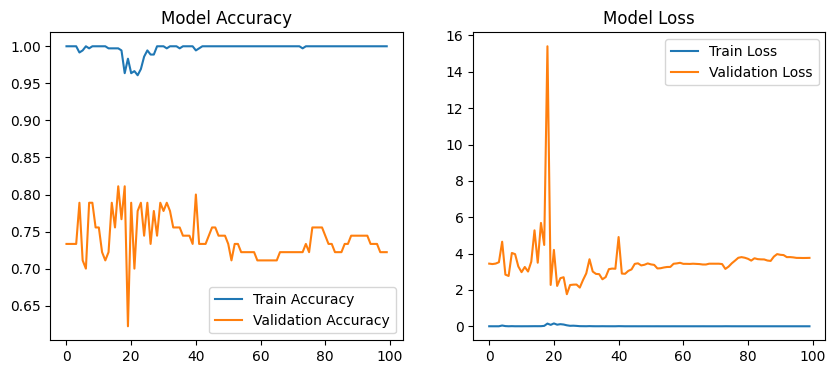

In [ ]:
# Split data and train the model
X_train, X_val, y_train, y_val = train_test_split(filtered_features, encoded_labels, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_val, y_val))

# Plotting training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


3/3 [==============================] - 0s 5ms/step - loss: 3.7635 - accuracy: 0.7222
Validation Accuracy: 0.7222, Validation Loss: 3.7635
3/3 [==============================] - 0s 3ms/step
                       precision    recall  f1-score   support

      Healthy control       0.17      0.12      0.14        17
Myocardial infarction       0.81      0.86      0.83        73

             accuracy                           0.72        90
            macro avg       0.49      0.49      0.49        90
         weighted avg       0.69      0.72      0.70        90



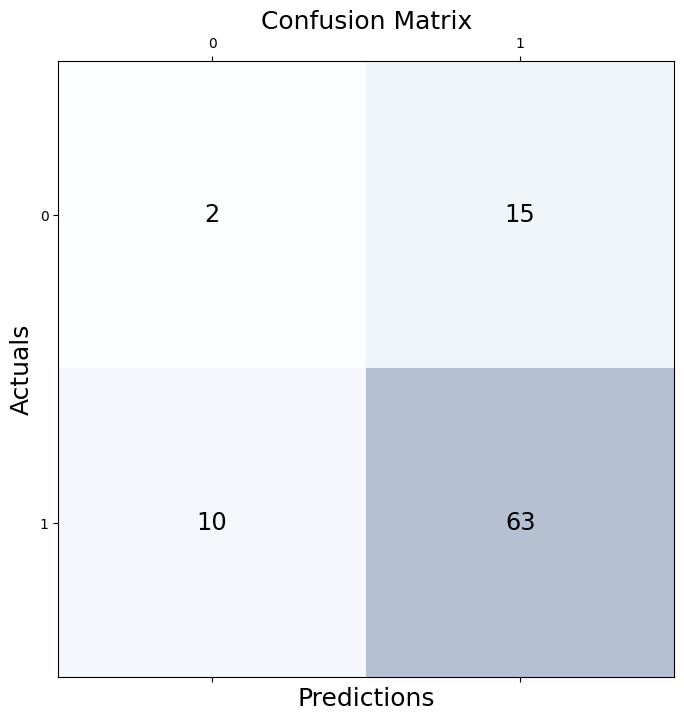

In [ ]:
# Evaluate the model on the validation set
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {test_accuracy:.4f}, Validation Loss: {test_loss:.4f}")

# Predictions and metrics
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)

# Generate a classification report
print(classification_report(y_val, predicted_classes, target_names=le.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(y_val, predicted_classes)
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()
